# Plotting rows and columns of molecules with MolsMatrixToGridImage

This guest post by Jeremy Monat (GitHub: [@bertiewooster](https://github.com/bertiewooster/)), who contributed `MolsMatrixToGridImage` to the RDKit, is the third of a few posts covering some of the new or improved features in the 2023.09.1 RDKit release.

[`MolsMatrixToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsMatrixToGridImage), new in RDKit 2023.09.1, is designed to easily plot a rectangular grid of molecules, that is, rows and columns of molecules.

## Comparing MolsMatrixToGridImage to MolsToGridImage

`MolsMatrixToGridImage` builds on [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsToGridImage). In fact, `MolsMatrixToGridImage` internally calls `MolsToGridImage`, so they can output the same images and formats.

The difference is that `MolsMatrixToGridImage` creates a rectangular row-and-column format by using nested input data structures. Each data substructure represents a row of molecules. `MolsMatrixToGridImage` automatically pads rows as needed so all rows are the length of the longest row, making it easy to plot molecules in a matrix without having to think about the length of each row.

As a minimal example, if we want to plot a single interhalogen molecule at various cells in a grid, for example to represent a spatial arrangement:

In [42]:
%%capture
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage
import copy

In [43]:
mol = Chem.MolFromSmiles("FCl")

both of the following produce the same grid image:

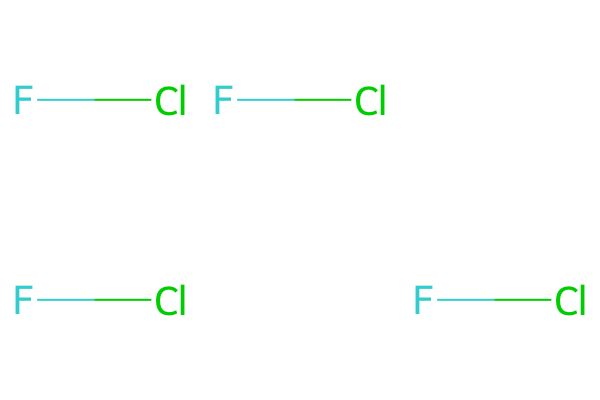

In [44]:
# MolsMatrixToGridImage usage
molsMatrix = [[mol, mol], [mol, None, mol]]
MolsMatrixToGridImage(molsMatrix=molsMatrix)

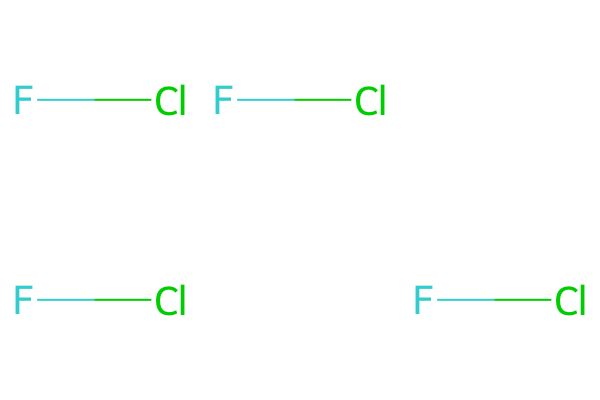

In [45]:
# MolsToGridImage usage
mols = [mol, mol, None, mol, None, mol]
MolsToGridImage(mols=mols, molsPerRow=3)

where we had to add the first `None` (null molecule) item for `MolsToGridImage` to produce the empty cell at the end of the first row.

The advantage of `MolsMatrixToGridImage` is that you need not manually pad shorter (narrower) rows, and you can provide molecules in a nested format that explicitly identifies each row.

While the nested data structure above for `MolsMatrixToGridImage` is a list of lists, you can use other pairs of iterables: a tuple of tuples, or a list of tuples, etc.

### When to use MolsToGridImage vs. MolsMatrixToGridImage

Use `MolsToGridImage` if you want to plot a series of molecules in the least amount of space, where the row that each molecule is on is not important.

Use `MolsMatrixToGridImage` if you want each row of molecules to represent something meaningful, and especially if the number of molecules per row can vary. The *columns* may or may not have meaning: You could plot an uninterrupted series of molecules in a row in no particular order, or you could assign molecules to columns based on some property—for example, a column may represent a spatial location. Or the columns may be used to space out molecules; for example in the retrosynthetic analysis tree below, the columns allow horizontal space for each subtree to avoid visually-confusing overlapping with adjacent subtrees.

A borderline situation is if each row will have the same number of molecules `n` (`n` = 2 below): you can create the same grid using either
- `MolsToGridImage(molsPerRow=n)`, for example `MolsToGridImage([mol1a, mol1b, mol2a, mol2b, mol3a, mol3b], molsPerRow=2)`.
- `MolsMatrixToGridImage` with `n` molecules in each row, for example `MolsMatrixToGridImage([[mol1a, mol1b], [mol2a, mol2b], [mol3a, mol3b]])`. You may find this format easier to use because each row is in its own sub-list. Also, you need not explicitly declare the number of molecules per row, so if you later change that number `n`, or have a different number of molecules on a given row, the grid will automatically adjust accordingly.

Note: Both `MolsMatrixToGridImage` and `MolsToGridImage` are Python functions; they are not available in C++.

## MolsMatrixToGridImage parameters

The only required parameter to `MolsMatrixToGridImage` is `molsMatrix`.

`MolsMatrixToGridImage` nests data structures one additional level beyond the analogous parameter in `MolsToGridImage`. The following table compares those parameters for the two functions, where the example parameters would produce the same output for their respective functions.

| `MolsToGridImage`<br>_`MolsMatrixToGridImage`_ | Elements mean                   | Parameter name                                   | Data structure                                                     | Example                                                                                                                                                                                      |
|----------------------------------------------------|-------------------------------|--------------------------------------------------|---------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Molecules                                          | RDKit molecule                | mols<br>_molsMatrix_                             | Iterable[mol]<br>_Iterable[Iterable[mol]]_                    | [FCl, FCl, None, FCl, None, FCl]<br>_[[FCl, FCl], [FCl, None, FCl]]_                                                                                                                         |
| Legends                                            | Legend text                   | legends<br>_legendsMatrix_                       | Iterable[str]<br>_Iterable[Iterable[str]]_                    | ["no highlighting", "bond highlighted", "", "F highlighted", "", "Cl and bond highlighted"]<br>_[["no highlighting", "bond highlighted"], ["F highlighted", "", "Cl and bond highlighted"]]_ |
| Highlight atoms                                    | Indices of atoms to highlight | highlightAtomLists<br>_highlightAtomListsMatrix_ | Iterable[Iterable[int]]<br>_Iterable[Iterable[Iterable[Int]]_ | [[], [], None, [0], None, [1]]<br>_[[[], []], [[0], None, [1]]]_                                                                                                                               |
| Highlight bonds                                    | Indices of bonds to highlight | highlightBondLists<br>_highlightBondListsMatrix_ | Iterable[Iterable[int]]<br>_Iterable[Iterable[Iterable[Int]]_ | [[], [0], None, [], None, [0]]<br>_[[[], [0]], [[], None, [0]]]_                                                                                                                               |

In the optional highlighting parameters (`highlightAtomLists`, `highlightAtomListsMatrix`, `highlightBondLists`, and `highlightBondListsMatrix`), to highlight nothing for a given molecule, you can use either `None` or an empty iterable such as `[]`.

If you provide the parameter names in the function call, for example `MolsMatrixToGridImage(molsMatrix=molsMatrix, legendsMatrix=legendsMatrix)`, be careful to include the suffix "Matrix" in those last three parameter names; if you use the parameter name from `MolsToGridImage`, such as `legends`, it will be passed to `MolsToGridImage` as a keyword argument and you will get an error like:

`TypeError: rdkit.Chem.Draw.IPythonConsole.ShowMols() got multiple values for keyword argument 'legends'`

Note that, unlike `MolsToGridImage`, `MolsMatrixToGridImage` does not take a `molsPerRow` parameter because `MolsMatrixToGridImage` automatically sets the number of molecules per row to the length of the longest row in `molsMatrix`. Other than that, and the per-molecule parameters having a more nested structure, `MolsMatrixToGridImage` can accept all the same parameters as `MolsToGridImage`: `useSVG`, `returnPNG`, and `**kwargs` such as `drawOptions`. Indeed, `MolsMatrixToGridImage` passes those three parameters to `MolsToGridImage`.

### Requirements for agreement of dimensions of per-molecule parameters in `MolsMatrixToGridImage`

`molsMatrix` sets the dimensions, and any other supplied Matrix (per-molecule) parameters must match those dimensions. In the example in the table above, `molsMatrix` has two rows (sub-lists), so `legendsMatrix`, `highlightAtomListsMatrix`, and `highlightBondListsMatrix` (if supplied) must also have two rows. Also, because the first row (sub-list) of `molsMatrix` has two columns (elements), that must true for those three other parameters. And because the second row (sub-list) of `molsMatrix` has three columns (elements), that must true for those three other parameters.

### Making blank cells

For blank cells at the end of a row, `MolsMatrixToGridImage` will automatically create them so that all rows have the same number of cells.

For blank cells in the middle of a row (when there is a molecule after the blank cell), you need to have a blank entry in the iterable. For molecules, this blank entry can either be `None` or a molecule with no atoms, for example using `Chem.MolFromSmiles("")`. For legends, a blank cell can be `""` (an empty string) but not `None`, which will give a type error. If you create molecules using `Chem.MolFromSmiles("")`, or use those SMILES strings to create legends, entering an empty string will prevent type errors in both situations. For example, this works:

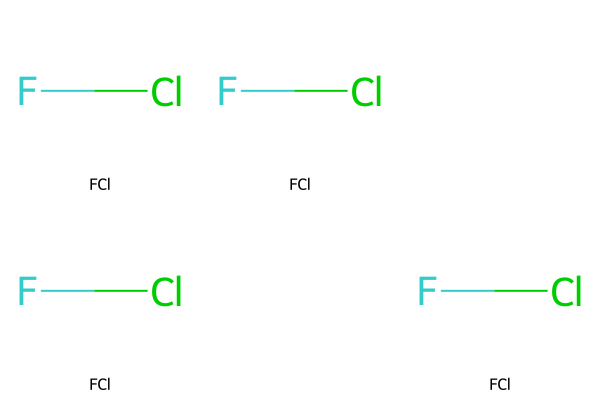

In [48]:
smilesMatrixEmptyString = [["FCl", "FCl"], ["FCl", "", "FCl"]]
molsMatrixEmptyString = [[Chem.MolFromSmiles(smiles) for smiles in row] for row in smilesMatrixEmptyString]
MolsMatrixToGridImage(molsMatrix=molsMatrixEmptyString, legendsMatrix=smilesMatrixEmptyString)

Whereas this gives a type error because `Chem.MolFromSmiles()` needs a string as input:

In [49]:
smilesMatrixNone = [["FCl", "FCl"], ["FCl", None, "FCl"]]
molsMatrixNone = [[Chem.MolFromSmiles(smiles) for smiles in row] for row in smilesMatrixNone]

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type NoneType

as does this because of the `None` element in `legendsMatrix`:

In [50]:
MolsMatrixToGridImage(molsMatrix=molsMatrixEmptyString, legendsMatrix=smilesMatrixNone)

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> from this Python object of type NoneType

## Example with all parameters for MolsMatrixToGridImage

Here is an example of supplying all parameters to `MolsMatrixToGridImage`.

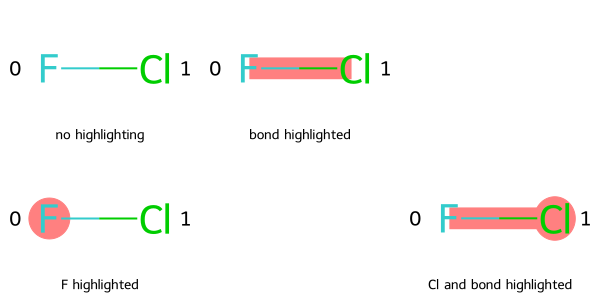

In [51]:
legendsMatrix = [["no highlighting", "bond highlighted"], ["F highlighted", "", "Cl and bond highlighted"]]
highlightAtomListsMatrix = [[[],[]], [[0], None, [1]]]
highlightBondListsMatrix = [[[],[0]], [[], None, [0]]]

# Add atom indices to drawing
dopts = rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True

MolsMatrixToGridImage(molsMatrix=molsMatrix, subImgSize=(200, 150), legendsMatrix=legendsMatrix, highlightAtomListsMatrix=highlightAtomListsMatrix, highlightBondListsMatrix=highlightBondListsMatrix, useSVG=False, returnPNG=False, drawOptions=dopts)

Here is the same image created using `MolsToGridImage`:

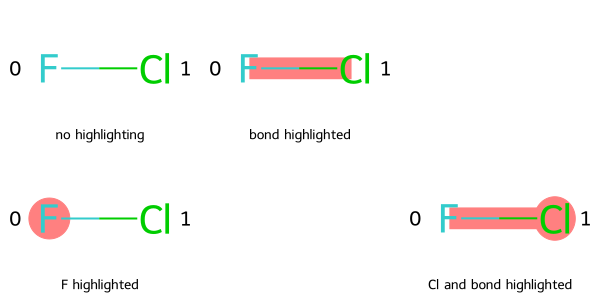

In [ ]:
legends = ["no highlighting", "bond highlighted", "", "F highlighted", "", "Cl and bond highlighted"]
highlightAtomLists = [[],[], None, [0], None, [1]]
highlightBondLists = [None,[0], [], [], None, [0]]

MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 150), legends=legends, highlightAtomLists=highlightAtomLists, highlightBondLists=highlightBondLists, useSVG=False, returnPNG=False, drawOptions=dopts)

## Use cases

Here are three example use cases. Each comes from an external blog post by the author, which is linked to in the use case's heading, and which explains more about the chemistry background and how the parameters given below are generated. In each case, we show the `MolsMatrixToGridImage` usage and then the same output using `MolsToGridImage`.

### [Synthetic accessibility](https://bertiewooster.github.io/2023/02/07/Are-the-Starting-Materials-for-Synthesizing-Your-Target-Molecules-Commercially-Available.html)

Given molecules you want to synthesize, and the reaction to create each, this utility determines the starting materials, checks whether they are commercially available per PubChem, and tells you whether each target is accessible—whether all its starting materials are commercially available.

Here, `MolsMatrixToGridImage` is useful because
- each row represents a synthetic target
- each target might have a different number of starting materials, and thus a different number of cells (columns). The first column represents the target. Subsequent columns represent the reactants, and are in no particular order.

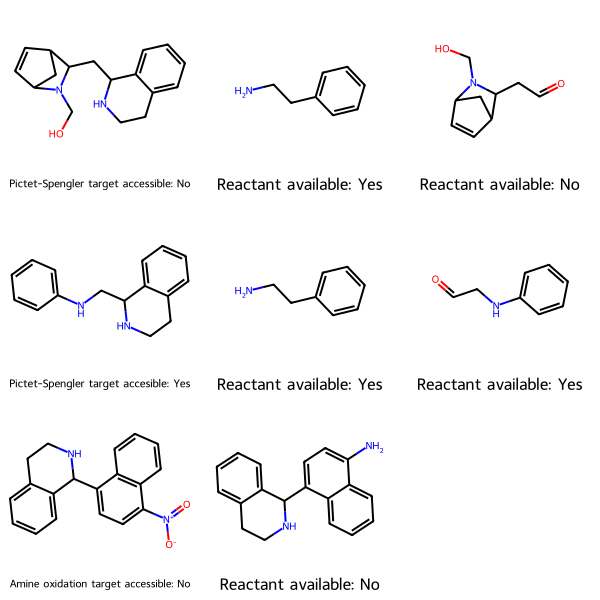

In [ ]:
# MolsMatrixToGridImage usage
synSmilesMatrix = [['OCN1C2CC(C=C2)C1CC1NCCc2ccccc12', 'NCCc1ccccc1', 'O=CCC1C2C=CC(C2)N1CO'], ['c1ccc(NCC2NCCc3ccccc32)cc1', 'NCCc1ccccc1', 'O=CCNc1ccccc1'], ['[O-][N+](=O)C1=CC=C(C2NCCc3ccccc23)C2=C1C=CC=C2', 'Nc1ccc(C2NCCc3ccccc32)c2ccccc12']]
synMolsMatrix = [[Chem.MolFromSmiles(smile) for smile in row] for row in synSmilesMatrix]
synLegendsMatrix = [['Pictet-Spengler target accessible: No', 'Reactant available: Yes', 'Reactant available: No'], ['Pictet-Spengler target accesible: Yes', 'Reactant available: Yes', 'Reactant available: Yes'], ['Amine oxidation target accessible: No', 'Reactant available: No']]
MolsMatrixToGridImage(molsMatrix=synMolsMatrix, legendsMatrix=synLegendsMatrix)

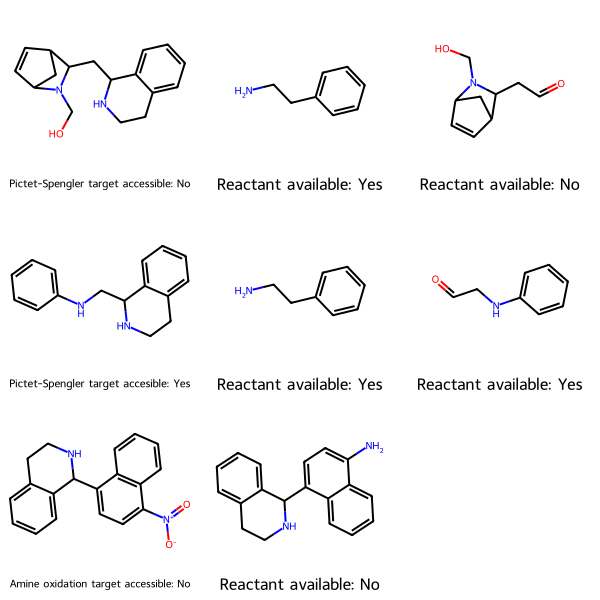

In [ ]:
# MolsToGridImage usage
synSmiles = ['OCN1C2CC(C=C2)C1CC1NCCc2ccccc12', 'NCCc1ccccc1', 'O=CCC1C2C=CC(C2)N1CO', 'c1ccc(NCC2NCCc3ccccc32)cc1', 'NCCc1ccccc1', 'O=CCNc1ccccc1', '[O-][N+](=O)C1=CC=C(C2NCCc3ccccc23)C2=C1C=CC=C2', 'Nc1ccc(C2NCCc3ccccc32)c2ccccc12', '']
synMols = [Chem.MolFromSmiles(smile) for smile in synSmiles]
synLegends = ['Pictet-Spengler target accessible: No', 'Reactant available: Yes', 'Reactant available: No', 'Pictet-Spengler target accesible: Yes', 'Reactant available: Yes', 'Reactant available: Yes', 'Amine oxidation target accessible: No', 'Reactant available: No', '']
MolsToGridImage(mols=synMols, legends=synLegends, molsPerRow=3)

### [Find the maximum common substructure, and groups off it, for a set of molecules](https://bertiewooster.github.io/2022/12/25/RDKit-Find-Groups-Off-Common-Core.html)

In drug discovery, the lead optimization step often involves creating analogues of a hit (a promising compound which produces a desired result in an assay) to optimize selectivity and minimize toxicity. Because it has historically been easier to chemically modify the periphery of the molecule (for example the functional groups) than the scaffold, it is helpful to compare the groups off of the common scaffold. A utility function uses the RDKit to find the maximum common substructure (MCS) between a set of molecules, then show the groups off of that core scaffold.

Here, `MolsMatrixToGridImage` is useful because
- each row represents a molecule in the set
- each of those molecules might have a different number of groups off the core scaffold.
The first column represents the molecule. Subsequent columns represent the groups off the core scaffold for that molecule, and are in no particular order.

The following example is for a set of two pyridinols.

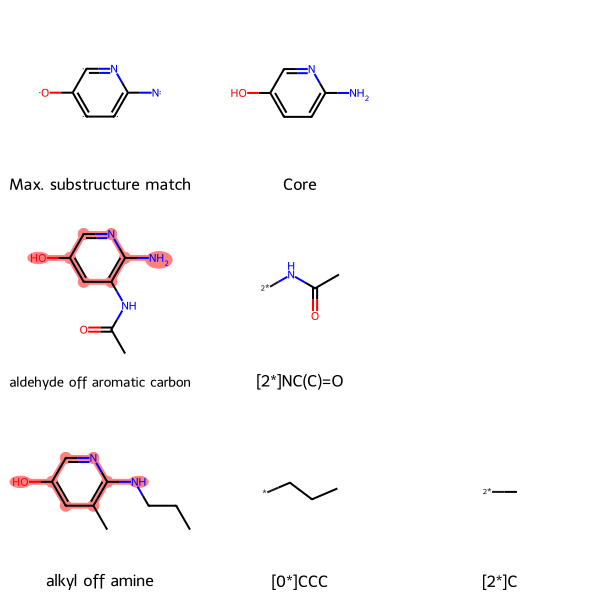

In [ ]:
# MolsMatrixToGridImage usage
mcsStringsMatrix = [['[#6]1:[#6](-[#8]):[#6]:[#7]:[#6](:[#6]:1)-[#7]', 'NC1:C:C:C(O):C:N:1'], ['c1c(O)cnc(N)c(NC(=O)(C))1', '[2*]NC(C)=O'], ['c1c(O)cnc(N(CCC))c1(C)', '[0*]CCC', '[2*]C']]
mcsMolsMatrix = [[Chem.MolFromSmiles(smile) for smile in row] for row in mcsStringsMatrix]

mcsLegends = [['Max. substructure match', 'Core'], ['aldehyde off aromatic carbon', '[2*]NC(C)=O'], ['alkyl off amine', '[0*]CCC', '[2*]C']]
mcsHighlightAtomLists = [[(), ()], [(0, 1, 2, 3, 4, 5, 7, 6), ()], [(0, 1, 2, 3, 4, 5, 10, 6), (), ()]]

mcsMolForMatrix = Chem.MolFromSmarts(mcsStringsMatrix[0][0])

# Align cores--optional, for easier visual comparison of molecules
subms = [mcsMolsMatrix[0][1]]
for row in mcsMolsMatrix[1:]:
    subms += [row[0]]
Chem.Compute2DCoords(mcsMolForMatrix)

for m in subms:
    _ = Chem.GenerateDepictionMatching2DStructure(m, mcsMolForMatrix)

MolsMatrixToGridImage(molsMatrix=mcsMolsMatrix, highlightAtomListsMatrix=mcsHighlightAtomLists, legendsMatrix=mcsLegends, useSVG=True)

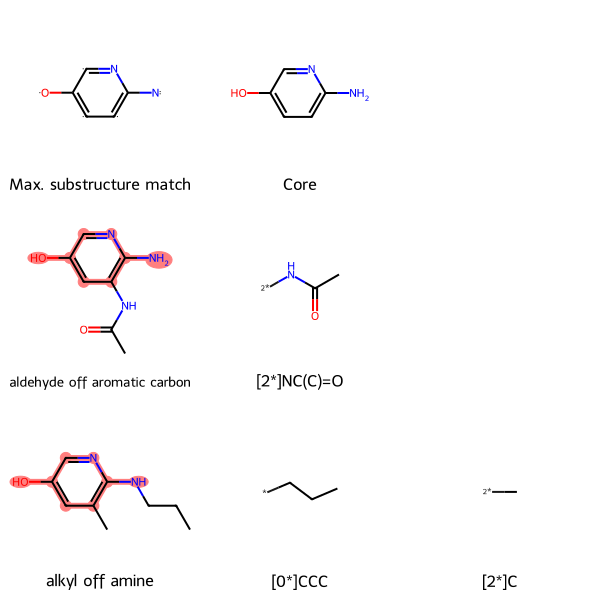

In [ ]:
# MolsToGridImage usage
mcsStrings = ['[#6]1:[#6](-[#8]):[#6]:[#7]:[#6](:[#6]:1)-[#7]', 'NC1:C:C:C(O):C:N:1', '', 'c1c(O)cnc(N)c(NC(=O)(C))1', '[2*]NC(C)=O', '', 'c1c(O)cnc(N(CCC))c1(C)', '[0*]CCC', '[2*]C']
molsPerRow = 3
mcsMols = [Chem.MolFromSmiles(smile) for smile in mcsStrings]
mcsLegends = ['Max. substructure match', 'Core', '', 'aldehyde off aromatic carbon', '[2*]NC(C)=O', '', 'alkyl off amine', '[0*]CCC', '[2*]C']
mcsHighlightAtomLists = [(), (), (), (0, 1, 2, 3, 4, 5, 7, 6), (), (), (0, 1, 2, 3, 4, 5, 10, 6), (), ()]

mcsMol = Chem.MolFromSmarts(mcsStrings[0])

# Align cores--optional, just for easier visual comparison of molecules
subms = [mcsMols[1]]
for mol in mcsMols[molsPerRow::molsPerRow]:
    subms += [mol]
Chem.Compute2DCoords(mcsMol)
for m in subms:
    _ = Chem.GenerateDepictionMatching2DStructure(m, mcsMol)

MolsToGridImage(mcsMols, highlightAtomLists=mcsHighlightAtomLists, legends=mcsLegends, molsPerRow=molsPerRow, useSVG=True)

### [Retrosynthetic analysis](https://bertiewooster.github.io/2022/11/11/RDKit-Recap-decomposition-tree.html)

Retrosynthetic analysis involves decomposing a target molecule into a set of fragments that could be combined to make the parent molecule using common reactions. The [Recap algorithm](https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee) by X. Lewell et al. accomplishes that. [Recap is implemented in the RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation). 

Here, `MolsMatrixToGridImage` is useful because
- each row represents a level of fragmentation, with the parent molecule at the top and increasing fragmentation towards the bottom
- we want to arrange the fragments hierarchically and allow horizontal space for each subtree to avoid visually-confusing overlapping with adjacent subtrees.
The columns have no inherent meaning, except that the parent molecule is in the first column, and fragments (of the parent molecule and its fragments) are arrayed to the right.

Here is an example retrosynthetic analysis of [6-(hydroxymethoxy)pyridin-2-yl]oxymethanol.

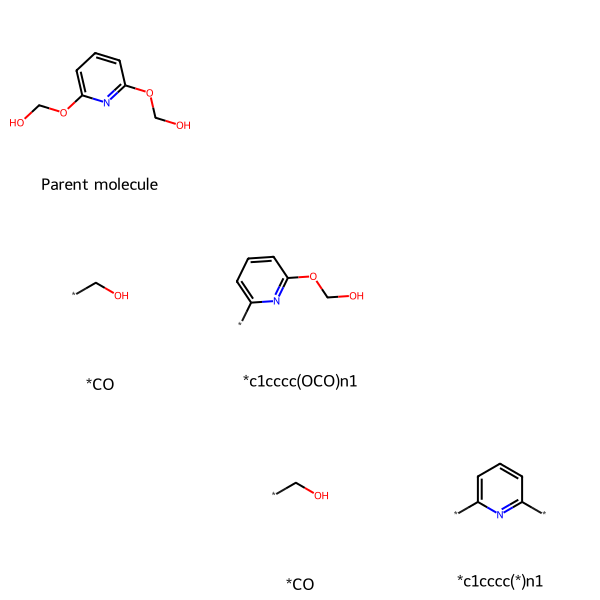

In [ ]:
# MolsMatrixToGridImage usage
retrosynSmilesMatrix = [['OCOc1cccc(OCO)n1', '', ''],
 ['*CO', '*c1cccc(OCO)n1', ''],
 ['', '*CO', '*c1cccc(*)n1']]
retrosynMolsMatrix = [[Chem.MolFromSmiles(smile) for smile in row] for row in retrosynSmilesMatrix]
retrosynLegendsMatrix = copy.deepcopy(retrosynSmilesMatrix)
retrosynLegendsMatrix[0][0] = "Parent molecule"
MolsMatrixToGridImage(retrosynMolsMatrix, legendsMatrix=retrosynLegendsMatrix)

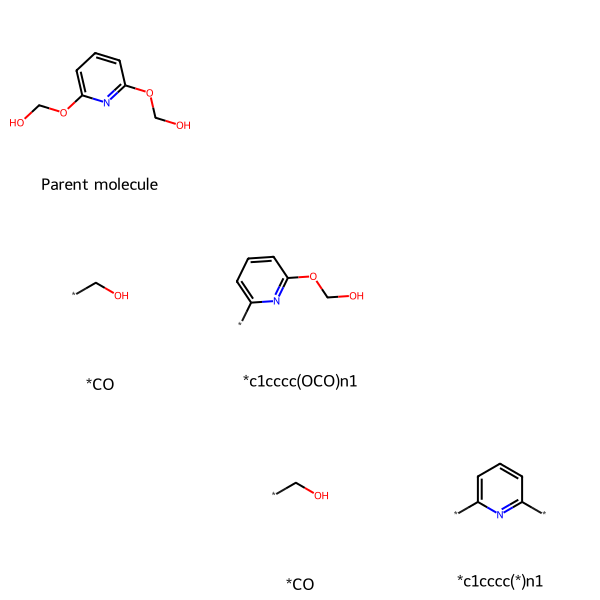

In [ ]:
# MolsToGridImage usage
retrosynSmiles = ['OCOc1cccc(OCO)n1', '', '', '*CO', '*c1cccc(OCO)n1', '', '', '*CO', '*c1cccc(*)n1']
retrosynMols = [Chem.MolFromSmiles(smile) for smile in retrosynSmiles]
retrosynLegends = ['Parent molecule', '', '', '*CO', '*c1cccc(OCO)n1', '', '', '*CO', '*c1cccc(*)n1']
MolsToGridImage(mols=retrosynMols, legends=retrosynLegends, molsPerRow=3)

## Your examples

If you use `MolsMatrixToGridImage` in a public project, please post a link in the comments below.

## 